<a href="https://colab.research.google.com/github/vipinkumarcp/pytorch/blob/main/ricedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install opendatasets --quiet

In [62]:
import opendatasets as od

In [63]:
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [64]:
import torch
import torch.nn as nn


In [65]:
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [67]:
data_df.dropna(inplace=True)
data_df.drop(['id'],axis=1,inplace=True)


In [68]:
print(data_df.shape)

(18185, 11)


In [69]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [70]:
data_df["Class"].unique()

array([1, 0])

In [71]:
data_df["Class"].value_counts()

,count
Class,
1,9985
0,8200


In [72]:
original_df = data_df.copy()

In [73]:
for column in data_df.columns:
  data_df[column]=data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [74]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [75]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [76]:
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test,test_size=0.5)

In [77]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [78]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    return self.X[index],self.Y[index]




In [79]:
training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test, Y_test)


In [80]:
train_dataloader = DataLoader(training_data, batch_size=32,shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=32,shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32,shuffle=True)


In [81]:
for x,y in train_dataloader:
  print(x)
  print("-===========")
  print(y)
  break

tensor([[0.8014, 0.8195, 0.8469, 0.9154, 0.7581, 0.8952, 0.6922, 0.7095, 0.8730,
         0.5490],
        [0.6639, 0.8908, 0.6491, 0.9770, 0.6293, 0.8148, 0.7609, 0.7133, 0.7156,
         0.7786],
        [0.8760, 0.8759, 0.8669, 0.9258, 0.8240, 0.9360, 0.6868, 0.7434, 0.8694,
         0.5732],
        [0.8898, 0.8772, 0.8823, 0.9220, 0.8460, 0.9433, 0.8758, 0.7516, 0.8639,
         0.5641],
        [0.8827, 0.8547, 0.9066, 0.9086, 0.8410, 0.9395, 0.7909, 0.7514, 0.8574,
         0.5348],
        [0.5733, 0.7779, 0.6459, 0.9593, 0.5476, 0.7571, 0.6190, 0.6491, 0.7461,
         0.6833],
        [0.9082, 0.8908, 0.8855, 0.9248, 0.8635, 0.9530, 0.6385, 0.7673, 0.8461,
         0.5707],
        [0.6809, 0.8764, 0.6825, 0.9686, 0.6485, 0.8252, 0.5304, 0.7134, 0.7338,
         0.7285],
        [0.6217, 0.7911, 0.6832, 0.9529, 0.5893, 0.7885, 0.7203, 0.6557, 0.7932,
         0.6570],
        [0.9471, 0.9051, 0.9180, 0.9201, 0.9578, 0.9732, 0.7507, 0.8595, 0.7031,
         0.5594],
        [0

In [82]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()

    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    x = self.input_layer(x)
    x  = self.linear(x)
    x = self.sigmoid(x)
    return x


model = MyModel().to(device)


In [83]:
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [84]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=1e-3)

In [85]:

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epocs = 10

for epoc in range(epocs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_validation = 0
  total_loss_validation = 0

  for data in train_dataloader:
    inputs,labels = data
    prediction = model(inputs).squeeze(1)

    batch_loss =  criterion(prediction,labels)

    total_loss_train +=  batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs,labels = data
      prediction = model(inputs).squeeze(1)

      batch_loss =  criterion(prediction,labels)

      total_loss_validation +=  batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()
      total_acc_validation += acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__()*100,4))


  print(f'''Epoch no. {epoc + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_validation/1000:.4f} Validation Accuracy: {(total_acc_validation/(validation_data.__len__())*100):.4f}''')
  print("="*50)








Epoch no. 1 Train Loss: 0.2535 Train Accuracy: 78.4429 Validation Loss: 0.0454 Validation Accuracy: 95.0513
Epoch no. 2 Train Loss: 0.1438 Train Accuracy: 97.3054 Validation Loss: 0.0193 Validation Accuracy: 97.9472
Epoch no. 3 Train Loss: 0.0641 Train Accuracy: 98.2010 Validation Loss: 0.0102 Validation Accuracy: 98.3138
Epoch no. 4 Train Loss: 0.0390 Train Accuracy: 98.3581 Validation Loss: 0.0070 Validation Accuracy: 98.5704
Epoch no. 5 Train Loss: 0.0294 Train Accuracy: 98.4916 Validation Loss: 0.0056 Validation Accuracy: 98.5337
Epoch no. 6 Train Loss: 0.0245 Train Accuracy: 98.5152 Validation Loss: 0.0047 Validation Accuracy: 98.6070
Epoch no. 7 Train Loss: 0.0219 Train Accuracy: 98.6016 Validation Loss: 0.0042 Validation Accuracy: 98.6070
Epoch no. 8 Train Loss: 0.0202 Train Accuracy: 98.6016 Validation Loss: 0.0040 Validation Accuracy: 98.5704
Epoch no. 9 Train Loss: 0.0192 Train Accuracy: 98.6566 Validation Loss: 0.0038 Validation Accuracy: 98.6070
Epoch no. 10 Train Loss: 0.0

In [86]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs,lables = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction,lables).item()

    total_loss_test += batch_loss_test

    acc = ((prediction).round() == lables).sum().item()

    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.57%


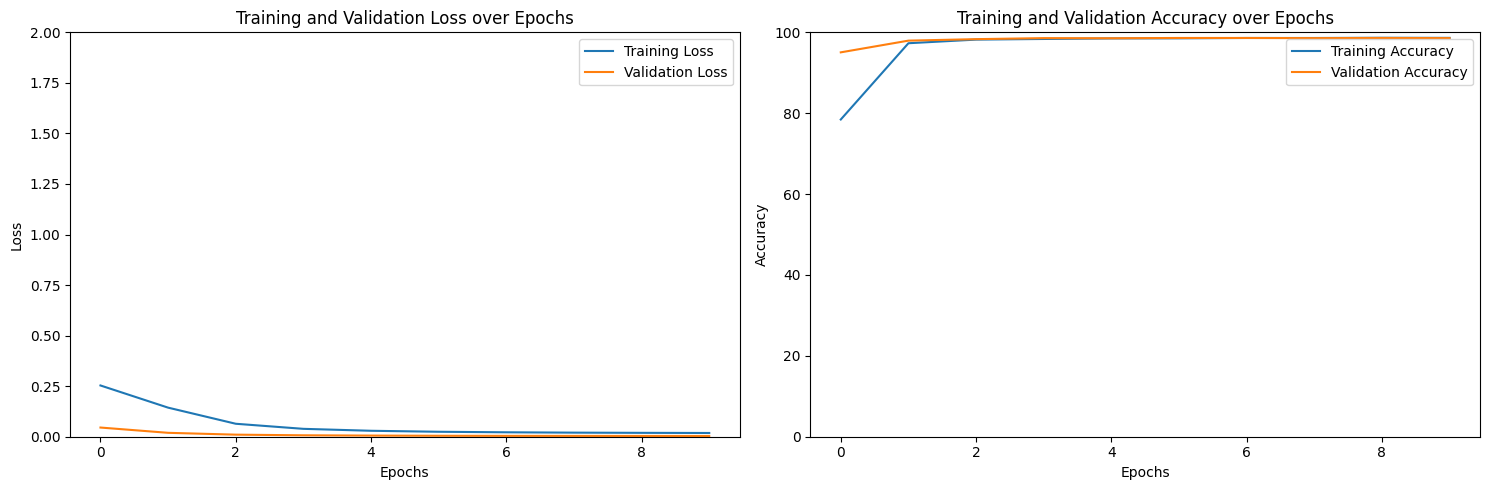

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [88]:
5
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))


Area: 4537
Major Axis Length: 92.229316
Minor Axis Length: 64.012769
Eccentricity: 0.719916
Convex Area: 4677
EquivDiameter: 76.004525
Extent: 0.657536
Perimeter: 273.085
Roundness: 0.764510
AspectRation: 1.440796
tensor([0.0224], device='cuda:0', grad_fn=<SigmoidBackward0>)
Class is:  0
